In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
train= pd.read_csv('../data/processed/final_train.csv')
train.head()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,verification_status,purpose,...,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,log_annual_inc,fico_score,credit_age_months,credit_age_years,cluster,charged_off
0,11000.0,11000.0,60,14.64,259.62,C,C3,RENT,Source Verified,debt_consolidation,...,65.0,4.0,0.0,4.0,4.698979,687.0,204,17.000000,1,0
1,15000.0,15000.0,36,7.90,469.36,A,A4,MORTGAGE,Verified,debt_consolidation,...,205.0,9.0,1.0,4.0,4.584749,732.0,358,29.833333,1,0
2,10000.0,10000.0,36,10.16,323.43,B,B1,RENT,Not Verified,credit_card,...,33.0,24.0,0.0,4.0,4.690205,732.0,349,29.083333,1,0
3,13000.0,13000.0,36,9.16,414.37,B,B2,RENT,Source Verified,credit_card,...,25.0,8.0,0.0,4.0,5.021193,677.0,219,18.250000,1,0
4,14000.0,14000.0,36,13.67,476.25,B,B5,RENT,Not Verified,debt_consolidation,...,240.0,12.0,1.0,8.0,4.966146,677.0,381,31.750000,1,0


In [3]:
X_train= train.loc[train.cluster == 1].drop(columns=['cluster', 'charged_off'], axis=1)
y_train= train.loc[train.cluster==1]['charged_off']

In [4]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
models= []
#Linear models
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('LGBM', LGBMClassifier()))
models.append(('XGB', XGBClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))


In [5]:
categorical_columns= X_train.select_dtypes(include='O').columns.tolist()
numerical_columns= X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [6]:
preprocessor= ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_columns),
    ('cat', TargetEncoder(cols=categorical_columns), categorical_columns)
])

In [9]:
from sklearn.model_selection import train_test_split

X_sample, _, y_sample, _= train_test_split(X_train, y_train, train_size=0.2, stratify=y_train, random_state=42)

In [10]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
results= []
names= []

kfold= StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models:
    pipeline= Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    cv_results= cross_val_score(pipeline, X_sample, y_sample, cv=kfold, scoring='f1', n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    message= f'{name}: {cv_results.mean()}, ({cv_results.std()})'
    print(message)

LR: 0.6423734320442871, (0.007508503296751955)
LDA: 0.5668258308046312, (0.00861843378333206)
KNN: 0.5161225055408785, (0.009810139574651185)
CART: 0.6566059138575567, (0.005502844990411676)
NB: 0.6691681951117758, (0.006978652195619496)
AB: 0.6649908994033888, (0.012277638169944484)
GBM: 0.7283195359997403, (0.0040827796922385156)
LGBM: 0.7558615601108963, (0.006782320729119275)
XGB: 0.7525935157898084, (0.005279609144578918)
RF: 0.7115120804536723, (0.00430448818204399)
ET: 0.6352200893845191, (0.005722061059284398)


In [13]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
results= []
names= []

kfold= StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models:
    pipeline= Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('sampling', SMOTE(random_state=42)),
        ('model', model)
    ])
    cv_results= cross_val_score(pipeline, X_sample, y_sample, cv=kfold, scoring='f1', n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    message= f'{name}: {cv_results.mean()}, ({cv_results.std()})'
    print(message)

LR: 0.6834338868886626, (0.004649447586230038)
LDA: 0.645633412566406, (0.005140765649215911)
KNN: 0.5424614677645991, (0.007669853133246764)
CART: 0.6500185092427946, (0.007141908285711227)
NB: 0.6593137485054523, (0.007065454229255159)
AB: 0.6806443316200799, (0.010271508884257026)
GBM: 0.7274860415824517, (0.005388976234142036)
LGBM: 0.7477397931482844, (0.006114294678055336)
XGB: 0.7497834958042268, (0.005636811832672563)
RF: 0.7219585436797932, (0.006138365800272403)
ET: 0.6874652949157598, (0.008238121408885314)


In [14]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'model__n_estimators': [300, 600],                
    'model__learning_rate': [0.05, 0.1, 0.2],         
    'model__max_depth': [3, 5, 7],                    
    'model__num_leaves': [15, 31, 63],               
    'model__min_child_samples': [10, 20, 50],        
    'model__subsample': [0.8, 1.0],                   
    'model__colsample_bytree': [0.8, 1.0],            
    'model__reg_alpha': [0, 0.1, 0.5, 1.0],           
    'model__reg_lambda': [1.0, 2.0],               
    'model__scale_pos_weight': [1, 2, 5]    
}

pipeline= Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier())
])

kfold= StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
grid= RandomizedSearchCV(estimator=pipeline,
                          param_distributions=param_grid,
                          scoring='f1',n_iter=10,cv=kfold,verbose=1,random_state=42,
                          n_jobs=-1)

grid_result= grid.fit(X_sample, y_sample)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Number of positive: 15439, number of negative: 57742
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4003
[LightGBM] [Info] Number of data points in the train set: 73181, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210970 -> initscore=-1.319088
[LightGBM] [Info] Start training from score -1.319088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [15]:
model= Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(subsample=0.8, scale_pos_weight=1, reg_lambda=1.0, 
                            reg_alpha= 0.1, num_leaves= 15, n_estimators= 600,min_child_samples=50, 
                            max_depth=5, learning_rate=0.1, colsample_bytree=1.0))
])
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 77195, number of negative: 288711
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4033
[LightGBM] [Info] Number of data points in the train set: 365906, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210969 -> initscore=-1.319091
[LightGBM] [Info] Start training from score -1.319091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [16]:
test= pd.read_csv('../data/processed/final_test.csv')
test.head()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,verification_status,purpose,...,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,log_annual_inc,fico_score,credit_age_months,credit_age_years,cluster,charged_off
0,31200.0,31200.0,60,12.69,704.96,C,C2,MORTGAGE,Verified,debt_consolidation,...,264.0,4.0,6.0,4.0,4.812920,782.0,389,32.416667,0,0
1,4400.0,4400.0,36,12.99,148.24,B,B4,RENT,Not Verified,debt_consolidation,...,112.0,13.0,0.0,8.0,4.477136,707.0,255,21.250000,1,0
2,10000.0,10000.0,60,10.99,217.38,B,B4,RENT,Source Verified,debt_consolidation,...,382.0,6.0,4.0,7.0,5.079185,692.0,506,42.166667,0,0
3,4400.0,4400.0,36,20.20,163.97,D,D5,RENT,Source Verified,debt_consolidation,...,90.0,1.0,0.0,4.0,5.267174,672.0,270,22.500000,1,0
4,20000.0,20000.0,60,12.88,453.84,C,C2,MORTGAGE,Not Verified,home_improvement,...,211.0,6.0,7.0,12.0,5.113947,687.0,328,27.333333,0,0


In [17]:
X_test= test.loc[test.cluster == 1].drop(columns=['charged_off', 'cluster'])
y_test= test.loc[test.cluster == 1]['charged_off']

In [18]:
y_pred= model.predict(X_test)

c:\Users\mwang\Desktop\ml\risk-bucketing-microservice\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [19]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

c:\Users\mwang\Desktop\ml\risk-bucketing-microservice\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


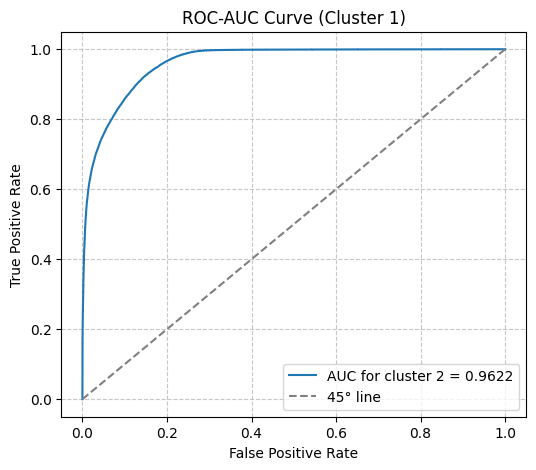

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve

false_pos, true_pos, _ = roc_curve(y_test.values, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(6, 5))
plt.plot(false_pos, true_pos, label=f"AUC for cluster 2 = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='45° line')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve (Cluster 1)')
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

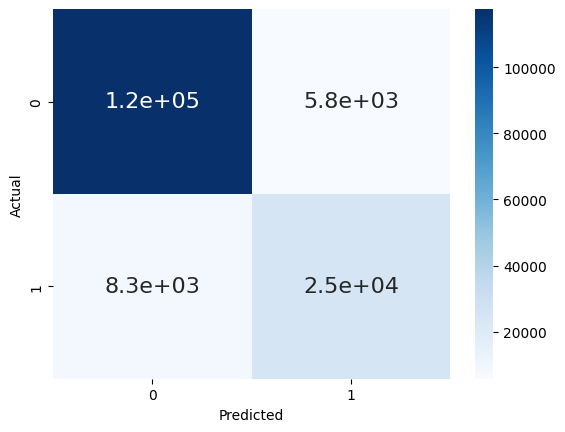

In [21]:
import numpy as np

df_cm= pd.DataFrame(confusion_matrix(y_test, y_pred), columns=np.unique(y_test), index= np.unique(y_test))
df_cm.index.name= 'Actual'
df_cm.columns.name= 'Predicted'
sns.heatmap(df_cm, annot=True, cmap='Blues', annot_kws={"size":16});

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94    123354
           1       0.81      0.75      0.78     32956

    accuracy                           0.91    156310
   macro avg       0.87      0.85      0.86    156310
weighted avg       0.91      0.91      0.91    156310



In [23]:
from sklearn.metrics import recall_score, precision_score, f1_score
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.7487862604685035
0.8102774585453948
0.7783192190629387


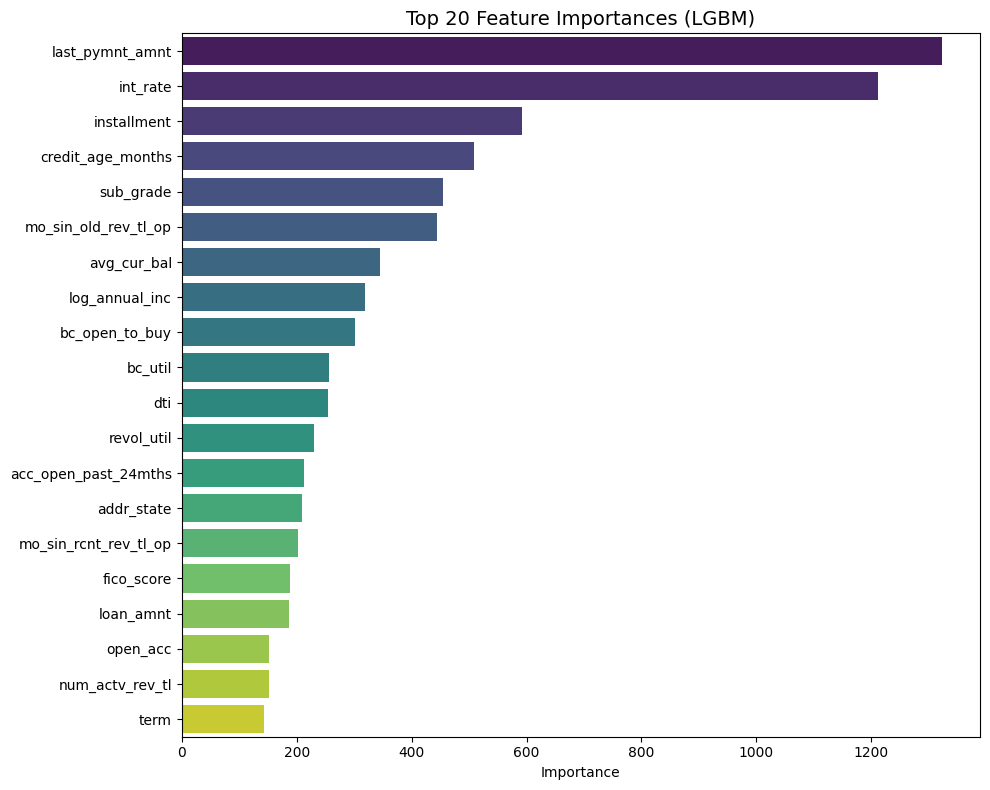

In [25]:
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

xgb_model = model.named_steps['model']
importances = xgb_model.feature_importances_

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feat_imp_df['Feature'] = (
    feat_imp_df['Feature']
    .str.replace(r'^(cat__|remainder__)', '', regex=True)
)

feat_imp_df['Feature'] = (
    feat_imp_df['Feature']
    .str.replace(r'^(num__|remainder__)', '', regex=True)
)
plt.figure(figsize=(10, 8))
sns.barplot(
    data=feat_imp_df.head(20),
    y='Feature',
    x='Importance',
    palette='viridis',
    hue='Feature',
    legend=False
)
plt.title('Top 20 Feature Importances (LGBM)', fontsize=14)
plt.xlabel('Importance')
plt.ylabel('')
plt.tight_layout()
plt.show()